# Control of a "spacecraft" platform with a reaction wheel

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_platform

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_platform)

<module 'ae353_platform' from '/Users/timothybretl/Documents/courses/AE353/09 - AE353 (Spring 2021)/Website/examples/day03_platform/ae353_platform.py'>

Create an instance of the robot simulator. This will open a window in which you should see the reaction wheel.

In [2]:
robot = ae353_platform.RobotSimulator(damping=0., pitch=0.)

Define the task by choosing a desired joint angle for the platform. Then, define a controller - that is, a function that maps a sensor measurement (the joint angle `q` and joint velocity `v` of the platform) to an actuator command (the joint torque `tau`).

In [3]:
# Choose a desired joint angle for the platform (rad)
q_des = 0.5 * np.pi

# Define a controller (by default, it chooses zero torque)
def controller(q, v, q_wheel, v_wheel):
    tau = 0.
    return tau

Run the simulation. It is a loop. At each iteration, we:
* get a sensor measurement
* choose an actuator command
* go forward one time step

We also log data so that we can plot it later, if we want.

In [4]:
# Restore the simulation to its initial state
#
# - could also use:
#
#       robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))
#
#   for some choice of initial joint angles q_platform and q_wheel
#   and initial joint velocities v_platform and v_wheel
#
robot.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q, v, q_wheel, v_wheel = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller(q, v, q_wheel, v_wheel)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q
    data['v'][step] = v
    data['q_wheel'][step] = q_wheel
    data['v_wheel'][step] = v_wheel
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step() 

Plot the results.

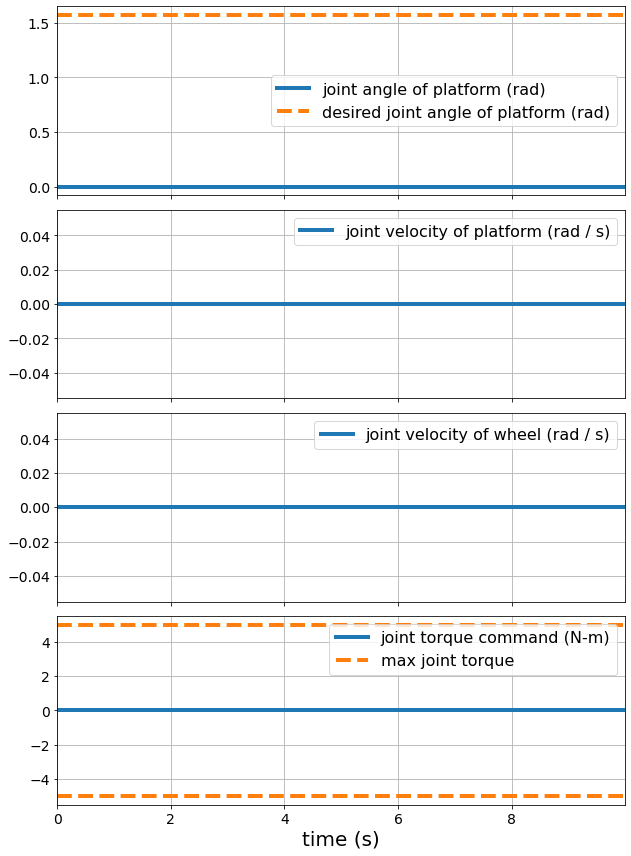

In [5]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# Plot joint angle of platform on first subplot
ax[0].plot(data['t'], data['q'], label='joint angle of platform (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * q_des, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot joint velocity of platform on second subplot
ax[1].plot(data['t'], data['v'], label='joint velocity of platform (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot joint velocity of wheel on third subplot
ax[2].plot(data['t'], data['v_wheel'], label='joint velocity of wheel (rad / s)', linewidth=4)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Plot joint torque on fourth subplot
ax[3].plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()